# Creating Lists of Words Related to a Specified Search Term

## This algorithm provides the following:
- Imports a dataframe of tweets
- Processes tweets and tokenizes words
- Uses Word Embeddings to convert words into vectors
- Determines related words by using cosine similarity within the vector space
- Generates a list, or lists, of words within the time delta(s) selected, ordered by cosine similarity.

### Imported Libraries
Libraries and modules below are used to import and process the tokens into vectors, removing extraneous words.

In [448]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from math import ceil
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import string
import re

### Tweet Import
Importing and parsing tweets into dataframe, converting the datestamp strings to datetime objects.

In [2]:
columns = ['tweet_id','timestamp','tweet_text','user_id',
           'tweet_coords','tweet_coords_list','tweet_long','tweet_lat','location',
           'enc_url','tweet_lang','hashtags']
tweet_full = pd.read_csv(r'./tweetCoords.csv',
                         header=None,
                         names=columns,
                         parse_dates=[1],
                         infer_datetime_format=True,
                         index_col='timestamp')

### Isolating Tweets by language (english)


In [3]:
tweet_full_en = tweet_full[tweet_full['tweet_lang'] == 'en']

### Text Cleaning and Tokenization Functions

In [4]:
tweet_stops = stopwords.words('english')
tweet_tokenizer = TweetTokenizer(strip_handles=True,preserve_case=False,reduce_len=True)

def clean_tweet(tweet):
#     takes input string and converts or removes characters depending on settings.
#     returns a string
#     convert case:
    tweet = tweet.lower()
#     remove URLs:
    tweet = re.sub('https?://\S+','',tweet)
#     remove @mentions, including those with a leading '-' or '.' : 
    tweet = re.sub('[-\.]?@\w+','',tweet)
#     remove punctuation, but not hashtags:
    tweet = tweet.translate(tweet.maketrans('','',string.punctuation.replace("#","")))
#     remove non-hashtag '#'.
    tweet = re.sub('#\B','',tweet)
#     remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
    tweet = re.sub(r'\b(amp|gt|lt)\b','',tweet)
#     drop numbers and words of < 4 characters.
    tweet = re.sub(r'\b\w{1,3}\b','',tweet)
    tweet = re.sub(r'\b\d+\b','',tweet)
    return tweet

def tokens_no_stopwords(tweet_as_string):
#     wrapper function that combines the tokenizer, cleaner, and stopword removal.
#     takes a string and returns a list of strings
    cleaned_tweet = clean_tweet(tweet_as_string)
    tweet_as_tokens = tweet_tokenizer.tokenize(cleaned_tweet)
    tweet_no_stops = [word for word in tweet_as_tokens if word not in tweet_stops]
    
    return tweet_no_stops

### Search Term
This is the term that will serve as the comparison for all later lists.

In [110]:
search_term = "irma"

### Related Words Dataframe and Time Deltas
This instantiates the dataframe for the related words and specifies the start, end, and time delta for the periods of related words.

In [384]:
related_words = pd.DataFrame()
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("24HR")
end_date = pd.to_datetime("2017-09-10 00:00:00")

### Related Word list quantity
This number specifies the number of words that will be returned in each list associated with the time periods specified above

In [268]:
top_num_words = 300

## Word Embeddings
### Converting Words to Vectors using the 'Word2Vec' library

- Iterate through each time period designated above
- Apply the tokenization and cleaning functions
- Convert the tokens to vectors

In [412]:
for i in range(1,11):
    for tweet_day in pd.date_range(start = tweet_date, end = end_date, freq = date_delta):
        tweet_text = tweet_full_en.loc[tweet_day:tweet_day + date_delta,"tweet_text"]

        tweets_tokens = tweet_text.apply(tokens_no_stopwords)
#         this line uses the for loop to iterate the minimum word count for inclusion in the vectors:
        vector_model = Word2Vec(tweets_tokens, min_count=i, window=7, workers=1, size=100, seed=1, sg=1)
#         this line uses the for loop to iterate the context window size for any given word
#         vector_model = Word2Vec(tweets_tokens, min_count=1, window=i, workers=1, size=100, seed=1, sg=1)
        
        word_matrix = vector_model.wv[vector_model.wv.vocab]
        vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
        terms_from_range = pd.DataFrame.from_records(vector_model.wv.most_similar(search_term,topn=top_num_words),
                                                     columns=[tweet_day,"score"])

        related_words = pd.concat([related_words,terms_from_range],axis=1)

SyntaxError: invalid syntax (<ipython-input-412-7bf56cefed5e>, line 6)

### Analysis on Cosine Similarity Values
#### Checking lists of words and F1 scores for effectiveness of analysis based upon similar words contained.

In [114]:
# cos_sim_values = related_words.iloc[:,1::2]

In [115]:
# related_words.iloc[:,1::2] = (cos_sim_values - cos_sim_values.min())* 100 / (cos_sim_values.max() - cos_sim_values.min())

In [465]:
related_words.iloc[90:100,0::2]

,2017-09-10 00:00:00,2017-09-10 00:00:00,2017-09-10 00:00:00,2017-09-10 00:00:00,2017-09-10 00:00:00,2017-09-10 00:00:00,2017-09-10 00:00:00,2017-09-10 00:00:00,2017-09-10 00:00:00,2017-09-10 00:00:00
90,#flstrong,windy,gente,spelling,allowing,flying,angry,blown,shop,onto
91,camping,checkout,eerie,fcnstorm,toward,petersburg,direct,throwback,wishing,approaches
92,4070mph,barely,allergic,hardest,boat,cold,powers,lady,chillin,massive
93,category,midday,salute,covered,walked,approaches,beyond,heads,fear,survival
94,confirms,outer,memes,matthew,beachside,irmas,type,effects,cross,hits
95,goodnight,alex,frankie,similar,rays,clemson,bowl,#irma,prepare,hurry
96,hunkering,#feederbands,cuba,repeat,stir,windy,tuned,shots,parents,location
97,vigorous,skies,furious,lakeland,towards,cozy,#update,weatherman,sunday,#huricaneirma
98,heresafe,cuba,shall,excited,ahead,used,#hurricaneirma,beyond,shift,direct
99,toward,historical,boards,footage,duck,sight,windy,hometown,early,boarded


## Identifying Relationships with Human Coded Data

### Using the list of related words to identify an Irma Related tweet.

Importing a list of human coded tweets for 'irma related'

In [117]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

The counts of human coded Irma related tweets: 0 = not related, 1 = 'irma' related

In [118]:
hc_encoded_counts = tweet_encoded.loc[:,['tweet_id','timestamp','irma_rel','tweet_text']].groupby('irma_rel').size()
print(hc_encoded_counts)

irma_rel
0    10792
1     8296
dtype: int64


In [388]:
related_words.iloc[0:6,0]

0         pass
1    currently
2       arrive
3     slightly
4       around
5    projected
Name: 2017-09-10 00:00:00, dtype: object

### Calculating F1 scores

Creating a function to evaluate F1 score for each iteration of the word list.

In [480]:
related_words_lists = related_words.iloc[:,0::2]

In [481]:
def WordsCWScoreList(position,column=0):
    related_word_list = list(related_words_lists.iloc[0:position,column])
    related_word_list.append(search_term)
    return "|".join(related_word_list)

This function takes a numeric position as an input. From there it:
- finds all of the words in the cosine-similarity ordered list for the range are at that position or above.
- creates a list of those words.
- appends the search term to that list.
- converts that list to a pipe-delimited string.
If the `related_word_list` dataframe has more than one set of related words (as columns) the the second argument allows subsequent columns' lists to be returned.

This pipe-delimited string can be used as the input of the `pd.Series.str.contains()` method as a regular expression for matching rows who contain one or more of the terms.

In [485]:
WordsCWScoreList(10,7)

'pass|move|currently|slightly|arrive|directly|#hurricaineirma|projected|hurricane|around|irma'

In [122]:
# def WordsMMScoreGreater(score):
#     related_word_list = list(related_words[related_words.iloc[:,1] > score].iloc[:,0])
#     related_word_list.append(search_term)
#     return "|".join(related_word_list)

For purposes of evaluating the effectiveneness of the related words threshold, there are 4 categories of tweets:
- human-coded 'irma-related' and the word list is a match (true positive)
- human-coded 'not irma-related' and the word list is a match (false positive)
- human-coded 'irma-related' and the word list is not a match (false negative)
- human-coded 'not irma-related' and the word list is not a match (true negative)

The `score_matrix` dataframe is initialized to be zeroes, to prevent contamination from previous iterations. The following for loop iterates over the `related_words_lists` dataframe from above to evaluate a tweet as related based upon containing one or more words of the subset of the word list for that particular window or minimum count.

In [403]:
score_matrix = pd.DataFrame(np.zeros(related_words_lists.shape))

In [493]:
f1_score(tweet_encoded.irma_rel,tweet_encoded.tweet_text.str.contains(WordsCWScoreList(239,5),flags=re.IGNORECASE))

0.7596559469676216

In [498]:
precision_score(tweet_encoded.irma_rel,tweet_encoded.tweet_text.str.contains(WordsCWScoreList(239,5),flags=re.IGNORECASE))

0.6962940644772522

In [497]:
recall_score(tweet_encoded.irma_rel,tweet_encoded.tweet_text.str.contains(WordsCWScoreList(239,5),flags=re.IGNORECASE))

0.8357039537126326

In [404]:
# The commented lines should be uncommented for debug purposes.
for i in range(0,related_words_lists.shape[1]):
#     print(pd.Timestamp.now().time())
    for j in range(0,related_words_lists.shape[0]):
        score_matrix.iloc[j,i]=f1_score(tweet_encoded.irma_rel,tweet_encoded.tweet_text.str.contains(WordsCWScoreList(j,i),flags=re.IGNORECASE))   
#     print(score_matrix.iloc[j,:])   

10:15:06.221784
0    0.731549
1    0.000000
2    0.000000
3    0.000000
4    0.000000
5    0.000000
6    0.000000
7    0.000000
8    0.000000
9    0.000000
Name: 299, dtype: float64
10:33:53.052474
0    0.731549
1    0.727039
2    0.000000
3    0.000000
4    0.000000
5    0.000000
6    0.000000
7    0.000000
8    0.000000
9    0.000000
Name: 299, dtype: float64
10:53:04.061579
0    0.731549
1    0.727039
2    0.729410
3    0.000000
4    0.000000
5    0.000000
6    0.000000
7    0.000000
8    0.000000
9    0.000000
Name: 299, dtype: float64
11:11:51.021415
0    0.731549
1    0.727039
2    0.729410
3    0.701540
4    0.000000
5    0.000000
6    0.000000
7    0.000000
8    0.000000
9    0.000000
Name: 299, dtype: float64
11:32:09.298321
0    0.731549
1    0.727039
2    0.729410
3    0.701540
4    0.695297
5    0.000000
6    0.000000
7    0.000000
8    0.000000
9    0.000000
Name: 299, dtype: float64
11:50:01.075187
0    0.731549
1    0.727039
2    0.729410
3    0.701540
4    0.695297
5   

In [254]:
import pickle

In [407]:
# pickle.dump(score_matrix,open('./score_matrix_seed_term_min_count_10E.pkl',"wb"))

In [401]:
# pickle.dump(related_words,open('./related_words_min_count_10E.pkl',"wb"))

In [428]:
related_test = pickle.load(open('./related_words_window_10E.pkl',"rb"))

In [418]:
score_matrix = pickle.load(open('./score_matrix_seed_term_window_10E.pkl',"rb"))

In [468]:
related_test.iloc[90:100,10]

90          peace
91           naps
92           past
93              3
94      periscope
95        balcony
96         direct
97          aghhh
98        effects
99    devastation
Name: 2017-09-10 00:00:00, dtype: object

In [488]:
score_matrix.iloc[68:73,5]

68    0.687397
69    0.688794
70    0.688887
71    0.741951
72    0.741793
Name: 5, dtype: float64

In [409]:
# np.all(score_matrix == score_matrix_test)

True

In [230]:
# for i in range(0,top_num_words,10):
#     print(str(i)+": ",end="")
#     print(f1_score(tweet_encoded.irma_rel,tweet_encoded.tweet_text.str.contains(WordsCWScoreList(i),flags=re.IGNORECASE)))      

In [126]:
# accuracy_score(tweet_encoded.irma_rel,tweet_encoded.tweet_text.str.contains(WordsCWScoreList(1),flags=re.IGNORECASE))

0.5696248952221291

In [232]:
import matplotlib.pyplot as plt
%matplotlib inline

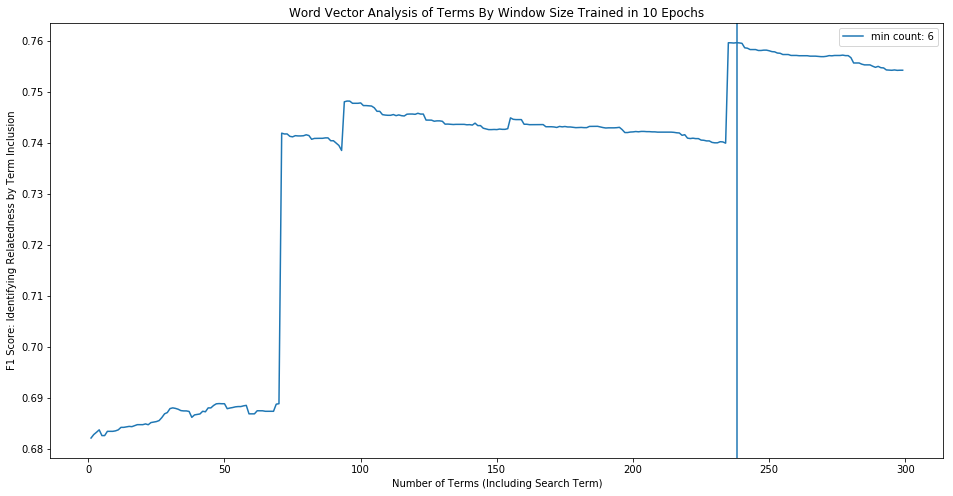

In [499]:
fig = plt.figure(figsize=(16,8))
plt.title("Word Vector Analysis of Terms By Window Size Trained in 10 Epochs")
plt.xlabel("Number of Terms (Including Search Term)")
plt.ylabel("F1 Score: Identifying Relatedness by Term Inclusion")
# for i in (range(1,11)):
#     plt.plot(score_matrix.iloc[1:,i-1],label="min count: "+str(i))
i=6
plt.plot(score_matrix.iloc[1:,i-1],label="min count: "+str(i))
plt.axvline(238)
plt.legend();

In the chart below, an increase in x represents a longer list of words whose inclusion would indicate an 'irma-related' tweet within the model. By allowing more words into this list, there is a larger number of tweets evaluated as a true positive result, but it also increases the false positives. The objective is to maximize the number of true positives, while minimizing false positives.

In [128]:
# fig = plt.figure(figsize=(16,8))
# ax = fig.subplots()

# color_list = ["#562a72", "#862d63", "#aaa939", "#7e9f35"]

# ax.stackplot(score_matrix.iloc[1:,:].index, 
#              score_matrix.iloc[1:,:].TruePos, 
#              score_matrix.iloc[1:,:].FalseNeg, 
#              score_matrix.iloc[1:,:].FalsePos, 
#              score_matrix.iloc[1:,:].TrueNeg,
#              labels=["True Positive","False Negative","False Positive","True Negative"],
#             colors = color_list)
# ax.axhline(hc_encoded_counts[1],linestyle="-.",color="w")
# ax.legend(loc='upper left')
# plt.show()

In [129]:
# print(score_matrix.iloc[ceil(related_words.iloc[50].score)])